# Calculating a relativistic orbit under the Schwarzschild metric

In [1]:
from sympy import *
from sympy.tensor.tensor import TensorIndexType, TensorIndex, TensorHead, tensor_indices, tensor_heads
from sympy.tensor.toperators import PartialDerivative

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
init_printing()

In [2]:
symbols(r'\ddot{r}')

## Lets define the Schwartzchild metric function

In [3]:
t, tau, r, phi, dt, dtau, dr, dphi, M, G  = symbols('t tau, r phi dt dτ, dr dφ M G')
r_dot = symbols(r'\dot{r}')
r_dotdot = symbols(r'\ddot{r}')
display((t, tau, r, phi, dt, dtau, dr, dphi, M, G, r_dot, r_dotdot))
schild = ((1 - 2 * M * G)/r) * dt**2  - dr**2 * ((1 - 2 * M * G)/r)**-1 - r**2 * dphi**2
schild

## Equations of motion

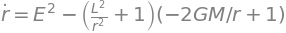

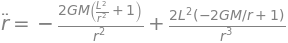

In [4]:
r, E, L, G, M = symbols('r E L G M')

rdot_squared = E**2 - (1 - 2*G*M/r) * (1 + L**2/r**2)
deriv_rdot_squared = diff(rdot_squared, r)
display(Eq(r_dot, dr/dtau))
display(Eq(r_dot, rdot_squared))
display(Eq(r_dotdot, deriv_rdot_squared))

In [5]:
d2r_dt2_func = lambdify((r, L, G, M), deriv_rdot_squared/2)

In [6]:


# Constants
G = 1  # Gravitational constant (in natural units)
M = 1  # Mass of the central object (e.g., black hole)
c = 1  # Speed of light (in natural units)
r_s = 2 * G * M  # Schwarzschild radius (2GM in natural units)

# Define the equations of motion for the Schwarzschild orbit

call_count = 0
def equations_of_motion(t, y, E, L):
    global call_count
    call_count += 1
    r, phi, dr_dt, dphi_dt  = y

    # Schwarzschild factor
    h = 1 - r_s / r
    
    # Radial acceleration in the Schwarzschild metric (corrected)
    # d2r_dt2 = -G * M / r**2 + (L**2 / r**3) * h  # Initial ChatGPT
    # d2r_dt2 = -(1-r_s/r) * L**2 / r**2 + (1 + L**2/r**2) * r_s / (2 * r**2)
    # d2r_dt2 = (1-r_s/r)*L**2/r**3 - (1-L**2/r**2) * r_s/(2 * r**2)   # My derivation
    # d2r_dt2 = ((2*L**2*r - 2*G*M*(3*L**2 + r**2))/r**4) / 2    # Wolfram derivation
    d2r_dt2 = d2r_dt2_func(r, L, M, G)  # SymPy solution
    
    # Correct angular acceleration
    d2phi_dt2 = -2 * L / r**3 * dr_dt
    dphi_dt = L/r**2

    # print(f"t={t:.3f}, r={r:.2f}, phi={phi:.3f}, dr_dt={dr_dt:.3f}, dphi_dt={dphi_dt:.3f}, d2r_dt2={d2r_dt2:.3f}, d2phi_dt2={d2phi_dt2:.3f}")

    return [dr_dt, dphi_dt, d2r_dt2, d2phi_dt2]

# Function to compute initial radial velocity (choosing correct branch)
def compute_initial_radial_velocity(E, L, r, sign):
    rad_velocity_squared = E**2 - (1 - 2*G*M/r) * (c**2 + L**2 / r**2)
    if abs(rad_velocity_squared) < 1E-12:
        rad_velocity_squared = 0
    
    # Ensure rad_velocity_squared is positive (physically meaningful)
    if rad_velocity_squared < 0:
        raise ValueError("Negative square root in radial velocity")
    
    return sign * np.sqrt(rad_velocity_squared)

def calc_L_E_for_circular_orbit(r0, eliptical_factor=1):
    # Passing eliptical e.g 0.7 or 1.3 to deviate from circular
    L = np.sqrt(M * r0**2 / (r0 - 3*M))
    E = np.sqrt ((1-2*M/r0) * (1 + M / (r0 -3*M)))
    L *= eliptical_factor
    print(f"r0={r0:.2f}, L={L:.3f}, E={E:.4f}")
    return L, E, r0
    

# Check if the orbit gets too close to the Schwarzschild radius
def check_orbit_proximity(r_vals, rs):
    print(f"Min radius = {np.min(r_vals):.2f}")
    if np.min(r_vals) <= rs:
        print("Warning: Orbit gets too close to the Schwarzschild radius! Minimum radius =", np.min(r_vals))

In [7]:
def run_orbit_calc(L, E, r0, tend):
# Key parameters are angular momentum, energy and initial radius

    phi0 = 0.0   # Initial angle
    dr_sign = -1  # Positive sign means the particle is moving outward initially
    dr0 = compute_initial_radial_velocity(E, L, r0, dr_sign)   # Initial radial velocity
    dphi0 = L / r0**2  # From conservation of angular momentum
    
    # Time span for the integration (proper time range)
    
    tau_span = (0, tend)
    y0 = [r0, phi0, dr0, dphi0]
    
    # Solve the system of differential equations
    solution = solve_ivp(equations_of_motion, tau_span, y0, args=(E, L), method='RK45', t_eval=np.linspace(0, tend, tend))

    print(f"{call_count} evaluations")
    return solution

In [8]:

def plot_orbit(solution, colour):
    # Extract results
    r_vals = solution.y[0]
    phi_vals = solution.y[1]
    time_vals = solution.t
    
    # Check if the orbit gets too close to the Schwarzschild radius
    check_orbit_proximity(r_vals, r_s)
    
    # Convert polar to Cartesian for plotting
    x_vals = r_vals * np.cos(phi_vals)
    y_vals = r_vals * np.sin(phi_vals)
    
    # Plot the orbit
    
    plt.plot(x_vals, y_vals, color=colour)

    # Want points at an equal spacing in time
    
    total_time = time_vals[-1]
    required_times = np.linspace(0, total_time, 50)
    r_at_times = np.interp(required_times, time_vals, r_vals)
    phi_at_times = np.interp(required_times, time_vals, phi_vals)
    x_vals = r_at_times * np.cos(phi_at_times)
    y_vals = r_at_times * np.sin(phi_at_times)
    plt.plot(x_vals, y_vals, color=colour, marker='.', lw=0)
    
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


r0=50.00, L=7.074, E=0.9902
146 evaluations
  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e+00 ...  4.999e+03  5.000e+03]
        y: [[ 5.000e+01  4.997e+01 ...  3.784e+01  3.783e+01]
            [ 0.000e+00  2.832e-03 ...  1.505e+01  1.505e+01]
            [-3.474e-02 -3.477e-02 ... -1.308e-02 -1.293e-02]
            [ 2.830e-03  2.834e-03 ...  4.982e-03  4.985e-03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 146
     njev: 0
      nlu: 0
Min radius = 37.22
r0=40.00, L=4.603, E=0.9878
472 evaluations
Min radius = 9.41
r0=37.00, L=3.807, E=0.9868
1104 evaluations
Min radius = 2.19


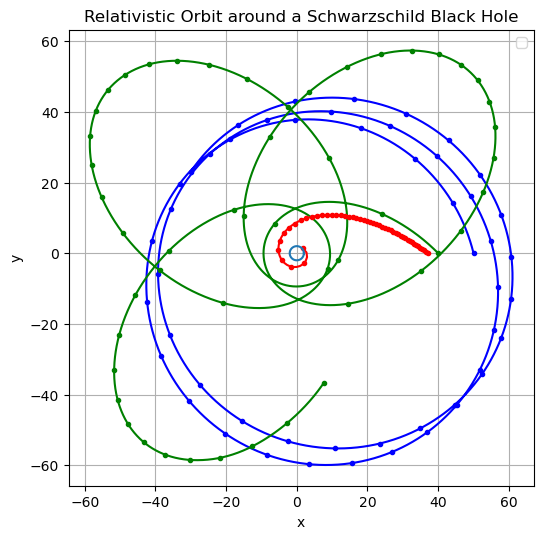

In [9]:
def main():
    plt.figure(figsize=(6, 6))
    
    L, E, r0 = calc_L_E_for_circular_orbit(r0=50.0, eliptical_factor=0.97)
    solution = run_orbit_calc(L, E, r0, tend=5000)
    print(solution)
    plot_orbit(solution, 'b')

    L, E, r0 = calc_L_E_for_circular_orbit(r0=40.0, eliptical_factor=0.7)
    solution = run_orbit_calc(L, E, r0, tend=5000)
    plot_orbit(solution, 'g')

    L, E, r0 = calc_L_E_for_circular_orbit(r0=37.0, eliptical_factor=0.6)
    solution = run_orbit_calc(L, E, r0, tend=2000)
    plot_orbit(solution, 'r')

    plt.title("Relativistic Orbit around a Schwarzschild Black Hole")

    event_horizon_coords = [(2*M*G * np.cos(phi), 2*M*G * np.sin(phi)) for phi in np.linspace(0, 2 * np.pi, 100)]
    # plt.plot(0, 0, 'ro', label="Central Mass")
    plt.plot(*zip(*event_horizon_coords))            
                            
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.show()

main()

In [10]:
a=[(1,2), (2,3), (4,5)]
list(zip(*a))